# <div style="text-align: center ">КУРСОВАЯ РАБОТА</div>
* * *

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Загружаем CSV файл и определяем целевую перменную

In [2]:
df_train = pd.read_csv('train.csv')
target_train = df_train['Price']

In [3]:
df_test = pd.read_csv('test.csv')

### <div style="text-align: center ">Подготовка таблицы TRAIN.</div>
* * *

#### <div style="text-align: center ">Проверяем для каких признаков присутствуют NaN значения.</div>  

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
Id               10000 non-null int64
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       7887 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     5202 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
dtypes: float64(8), int64(9), object(3)
memory usage: 1.5+ MB


#### <div style="text-align: center ">Визуализация распределения цен на квартиры.</div> 

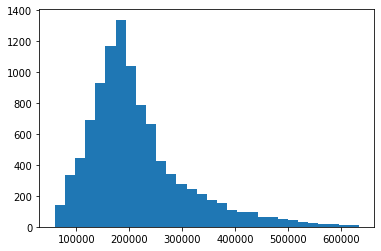

In [5]:
plt.hist(df_train['Price'], bins=30)
plt.show()

In [6]:
DF_train = pd.DataFrame(df_train)
DF_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [7]:
DF_train.shape

(10000, 20)

#### <div style="text-align: center ">Корректировка Rooms.</div>

Сгруппируем квартиры по комнатам

In [8]:
DF_train["Rooms"].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

Т.к. "двушек" большинство, заменим "0", "10" и "19" комнатные аномалии на "двушки"

In [9]:
DF_train['Rooms'] = np.where(DF_train['Rooms'] == 0, 2, DF_train['Rooms'])
DF_train['Rooms'] = np.where(DF_train['Rooms'] == 10, 2, DF_train['Rooms'])
DF_train['Rooms'] = np.where(DF_train['Rooms'] == 19, 2, DF_train['Rooms'])

In [10]:
DF_train["Rooms"].value_counts()

2.0    3891
1.0    3705
3.0    2235
4.0     150
5.0      18
6.0       1
Name: Rooms, dtype: int64

#### <div style="text-align: center ">Корректировка LifeSquare.</div>

Сформируем группировку квартиры по комнатам, при этом в качестве метрики укажем долю жилой площади в общей площади

In [11]:
DF_train["LifeSquare_perc"] = DF_train['LifeSquare'] / DF_train['Square']
qqq = DF_train.groupby(DF_train['Rooms']).LifeSquare_perc.median()
qqq

Rooms
1.0    0.565497
2.0    0.627626
3.0    0.647943
4.0    0.663481
5.0    0.688025
6.0    0.651396
Name: LifeSquare_perc, dtype: float64

Заполняем пустые значения жилой площади как "Общая площадь умноженная на медианное значение доли жилой в общей".

Причем корректировка происходит отдельно по количество комнат, т.е. однушки отдельно, двушки отдельно и т.д.

In [12]:
def LifeSquare_edit (model, rooms):
    i = 1
    while i <= rooms:
        model.loc[(model['Rooms']==i) & (pd.isnull(model.LifeSquare)), 'LifeSquare'] = model.Square * qqq[i]
        i = i+1

In [13]:
LifeSquare_edit(DF_train, 6)

Удалим добавленный ранее вычисляемый столбец "LifeSquare_perc"

In [14]:
DF_train.drop('LifeSquare_perc', axis=1, inplace=True)

Заполняем нелогичные данные "жилая площадь больше общей площади"

In [15]:
def LifeSquare_above_Square (model, rooms):
    i = 1
    while i <= rooms:
        model.loc[(model['Rooms']==i) & (model['LifeSquare']>model['Square']), 'LifeSquare'] = model.Square * qqq[i]
        i = i + 1

In [16]:
LifeSquare_above_Square(DF_train, 6)

In [17]:
DF_train.shape

(10000, 20)

#### <div style="text-align: center ">Корректировка HouseFloor.</div>

"0" количество этажей в доме приравниваем этажу квартиры

In [18]:
DF_train["HouseFloor"].value_counts().head(10)

17.0    2331
9.0     1389
12.0    1074
5.0     1031
14.0     625
16.0     576
1.0      497
25.0     374
22.0     343
0.0      269
Name: HouseFloor, dtype: int64

In [19]:
DF_train.loc[DF_train['HouseFloor']==0, 'HouseFloor'] = DF_train.Floor

Если этаж квартиры выше, чем этажность дома - этажность дома указываем как номер этажа квартиры

In [20]:
DF_train.loc[DF_train['Floor'] > DF_train['HouseFloor'], 'HouseFloor'] = DF_train.Floor

#### <div style="text-align: center ">Корректировка Healthcare_1 и Helthcare_2.</div>

Пропуски по показателю Healthcare_1 заполним медианными значениями

In [21]:
hc_median = DF_train["Healthcare_1"].median()
DF_train["Healthcare_1"].fillna(hc_median, inplace=True)

Установим показатель Helthcare_2 категориальным принудительно

In [22]:
DF_train["Helthcare_2"] = DF_train["Helthcare_2"].astype("category")

In [23]:
DF_train = pd.get_dummies(DF_train)

И еще раз проверим все ли признаки заполнены

In [24]:
DF_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 29 columns):
Id               10000 non-null int64
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       10000 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     10000 non-null float64
Shops_1          10000 non-null int64
Price            10000 non-null float64
Ecology_2_A      10000 non-null uint8
Ecology_2_B      10000 non-null uint8
Ecology_3_A      10000 non-null uint8
Ecology_3_B      10000 non-null uint8
Helthcare_2_0    10000 non-null uint8
Helthcare_2_1    10000 non-null uint8
Helthcare_2_2    10000 non-null uint8
He

#### <div style="text-align: center ">Корректировка KitchenSquare.</div>

In [25]:
DF_train["KitchenSquare"].value_counts().head(10)

1.0     2460
8.0     1306
5.0     1169
10.0    1075
6.0     1038
9.0      843
0.0      697
7.0      609
12.0     249
11.0     233
Name: KitchenSquare, dtype: int64

Добавим вычисляемый столбец "Доля кухни в общей площади" и сформируем группировку медианных значений долей.

In [26]:
DF_train['KitchenSquare_X'] = DF_train['KitchenSquare'] / DF_train['Square']
aaa = DF_train.groupby(DF_train['Rooms']).KitchenSquare_X.median()
aaa

Rooms
1.0    0.166202
2.0    0.120033
3.0    0.102137
4.0    0.091560
5.0    0.075200
6.0    0.100986
Name: KitchenSquare_X, dtype: float64

Заменим площадь "меньше либо равно 3м2" на значения как "доля кухни на общую площадь" отдельно по комнатности

In [27]:
def KitchenSquare_mean (model, rooms):
    i = 1
    while i <= rooms:
        model.loc[(model['Rooms']==i) & (model['KitchenSquare']<=3), 'KitchenSquare'] = model.Square * aaa[i]
        i = i + 1

In [28]:
KitchenSquare_mean(DF_train, 6)

Удалим вычисляемый столбец "KitchenSquare_X"

In [29]:
DF_train.drop('KitchenSquare_X', axis=1, inplace=True)

#### <div style="text-align: center ">Корректировка HouseYear.</div>

Год постройки домов младше 2019 года установим 2019

In [30]:
DF_train.loc[DF_train['HouseYear']>2019, 'HouseYear'] = 2019

### <div style="text-align: center ">Подготовка таблицы TEST.</div>
* * *

#### <div style="text-align: center ">Проверяем для каких признаков присутствуют NaN значения.</div>  

In [31]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
Id               5000 non-null int64
DistrictId       5000 non-null int64
Rooms            5000 non-null float64
Square           5000 non-null float64
LifeSquare       3959 non-null float64
KitchenSquare    5000 non-null float64
Floor            5000 non-null int64
HouseFloor       5000 non-null float64
HouseYear        5000 non-null int64
Ecology_1        5000 non-null float64
Ecology_2        5000 non-null object
Ecology_3        5000 non-null object
Social_1         5000 non-null int64
Social_2         5000 non-null int64
Social_3         5000 non-null int64
Healthcare_1     2623 non-null float64
Helthcare_2      5000 non-null int64
Shops_1          5000 non-null int64
Shops_2          5000 non-null object
dtypes: float64(7), int64(9), object(3)
memory usage: 742.3+ KB


In [32]:
DF_test = pd.DataFrame(df_test)
DF_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


In [33]:
DF_test.shape

(5000, 19)

#### <div style="text-align: center ">Корректировка Rooms.</div>

Сгруппируем квартиры по комнатам

In [34]:
DF_test["Rooms"].value_counts()

2.0     2030
1.0     1769
3.0     1099
4.0       90
5.0        7
0.0        2
6.0        2
17.0       1
Name: Rooms, dtype: int64

Т.к. "двушек" большинство, заменим "0" и "17" комнатные аномалии на "двушки"

In [35]:
DF_test['Rooms'] = np.where(DF_test['Rooms'] == 0, 2, DF_test['Rooms'])
DF_test['Rooms'] = np.where(DF_test['Rooms'] == 17, 2, DF_test['Rooms'])

In [36]:
DF_test["Rooms"].value_counts()

2.0    2033
1.0    1769
3.0    1099
4.0      90
5.0       7
6.0       2
Name: Rooms, dtype: int64

#### <div style="text-align: center ">Корректировка LifeSquare.</div>

Сформируем группировку квартиры по комнатам, при этом в качестве метрики укажем долю жилой площади в общей площади

In [37]:
DF_test["LifeSquare_perc"] = DF_test['LifeSquare'] / DF_test['Square']
qqq1 = DF_test.groupby(DF_test['Rooms']).LifeSquare_perc.median()
qqq1

Rooms
1.0    0.569218
2.0    0.628714
3.0    0.650951
4.0    0.664449
5.0    0.639593
6.0    0.465929
Name: LifeSquare_perc, dtype: float64

Заполняем пустые значения жилой площади как "Общая площадь умноженная на медианное значение доли жилой в общей".

Причем корректировка происходит отдельно по количество комнат, т.е. однушки отдельно, двушки отдельно и т.д.

In [38]:
def LifeSquare_test_edit (model, rooms):
    i = 1
    while i <= rooms:
        model.loc[(model['Rooms']==i) & (pd.isnull(model.LifeSquare)), 'LifeSquare'] = model.Square * qqq1[i]
        i = i+1

In [39]:
LifeSquare_test_edit(DF_test, 6)

Удалим добавленный ранее вычисляемый столбец "LifeSquare_perc"

In [40]:
DF_test.drop('LifeSquare_perc', axis=1, inplace=True)

Заполняем нелогичные данные "жилая площадь больше общей площади"

In [41]:
def LifeSquare_above_Square_test (model, rooms):
    i = 1
    while i <= rooms:
        model.loc[(model['Rooms']==i) & (model['LifeSquare']>model['Square']), 'LifeSquare'] = model.Square * qqq1[i]
        i = i + 1

In [42]:
LifeSquare_above_Square_test(DF_test, 6)

In [43]:
DF_test.shape

(5000, 19)

#### <div style="text-align: center ">Корректировка HouseFloor.</div>

"0" количество этажей в доме приравниваем этажу квартиры

In [44]:
DF_test["HouseFloor"].value_counts().head(10)

17.0    1151
9.0      724
5.0      550
12.0     526
14.0     344
16.0     235
1.0      230
22.0     193
25.0     179
0.0      131
Name: HouseFloor, dtype: int64

In [45]:
DF_test.loc[DF_test['HouseFloor']==0, 'HouseFloor'] = DF_test.Floor

Если этаж квартиры выше, чем этажность дома - этажность дома указываем как номер этажа квартиры

In [46]:
DF_test.loc[DF_test['Floor'] > DF_test['HouseFloor'], 'HouseFloor'] = DF_test.Floor

#### <div style="text-align: center ">Корректировка Healthcare_1 и Helthcare_2.</div>

Пропуски по показателю Healthcare_1 заполним медианными значениями

In [47]:
hc_median_test = DF_test["Healthcare_1"].median()
DF_test["Healthcare_1"].fillna(hc_median_test, inplace=True)

Установим показатель Helthcare_2 категориальным принудительно

In [48]:
DF_test["Helthcare_2"] = DF_test["Helthcare_2"].astype("category")

In [49]:
DF_test = pd.get_dummies(DF_test)

И еще раз проверим все ли признаки заполнены

In [50]:
DF_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 28 columns):
Id               5000 non-null int64
DistrictId       5000 non-null int64
Rooms            5000 non-null float64
Square           5000 non-null float64
LifeSquare       5000 non-null float64
KitchenSquare    5000 non-null float64
Floor            5000 non-null int64
HouseFloor       5000 non-null float64
HouseYear        5000 non-null int64
Ecology_1        5000 non-null float64
Social_1         5000 non-null int64
Social_2         5000 non-null int64
Social_3         5000 non-null int64
Healthcare_1     5000 non-null float64
Shops_1          5000 non-null int64
Ecology_2_A      5000 non-null uint8
Ecology_2_B      5000 non-null uint8
Ecology_3_A      5000 non-null uint8
Ecology_3_B      5000 non-null uint8
Helthcare_2_0    5000 non-null uint8
Helthcare_2_1    5000 non-null uint8
Helthcare_2_2    5000 non-null uint8
Helthcare_2_3    5000 non-null uint8
Helthcare_2_4    5000 non-nu

#### <div style="text-align: center ">Корректировка KitchenSquare.</div>

In [51]:
DF_test["KitchenSquare"].value_counts().head(10)

1.0     1191
5.0      612
8.0      606
6.0      595
10.0     558
9.0      417
0.0      335
7.0      297
12.0     132
11.0     107
Name: KitchenSquare, dtype: int64

Добавим вычисляемый столбец "Доля кухни в общей площади" и сформируем группировку медианных значений долей.

In [52]:
DF_test['KitchenSquare_X'] = DF_test['KitchenSquare'] / DF_test['Square']
aaa1 = DF_test.groupby(DF_test['Rooms']).KitchenSquare_X.median()
aaa1

Rooms
1.0    0.167095
2.0    0.121768
3.0    0.100830
4.0    0.089547
5.0    0.075961
6.0    0.035802
Name: KitchenSquare_X, dtype: float64

Заменим площадь "меньше либо равно 3м2" на значения как "доля кухни на общую площадь" отдельно по комнатности

In [53]:
def KitchenSquare_test_mean (model, rooms):
    i = 1
    while i <= rooms:
        model.loc[(model['Rooms']==i) & (model['KitchenSquare']<=3), 'KitchenSquare'] = model.Square * aaa1[i]
        i = i + 1

In [54]:
KitchenSquare_test_mean(DF_test, 6)

Удалим вычисляемый столбец "KitchenSquare_X"

In [55]:
DF_test.drop('KitchenSquare_X', axis=1, inplace=True)

#### <div style="text-align: center ">Корректировка HouseYear.</div>

Год постройки домов младше 2019 года установим 2019

In [56]:
DF_test.loc[DF_test['HouseYear']>2019, 'HouseYear'] = 2019

### <div style="text-align: center ">Сохранение датафреймов.</div>
* * *

In [57]:
DF_train.to_pickle('DF_train.pkl')
DF_test.to_pickle('DF_test.pkl')

.                                                                                                                      .

### <div style="text-align: center ">Импорт модели.</div>
* * *

In [58]:
import numpy as np
import pandas as pd
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse
from sklearn.model_selection import KFold, GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [59]:
import warnings
warnings.filterwarnings('ignore')

In [60]:
def evaluate_preds(true_values, pred_values):
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "MAE:\t" + str(round(mae(true_values, pred_values), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3)))
    
    plt.figure(figsize=(10,10))
    
    sns.scatterplot(x=pred_values, y=true_values)
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    plt.show()

Импортируем отформатированные данные

In [61]:
DF = pickle.load(open('DF_train.pkl', 'rb'))
DF.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Shops_1',
 'Price',
 'Ecology_2_A',
 'Ecology_2_B',
 'Ecology_3_A',
 'Ecology_3_B',
 'Helthcare_2_0',
 'Helthcare_2_1',
 'Helthcare_2_2',
 'Helthcare_2_3',
 'Helthcare_2_4',
 'Helthcare_2_5',
 'Helthcare_2_6',
 'Shops_2_A',
 'Shops_2_B']

### <div style="text-align: center ">Отбор признаков.</div>
* * *

In [62]:
feature = ['DistrictId',
             'Rooms',
             'Square',
             'LifeSquare',
             'KitchenSquare',
             'Floor',
             'HouseFloor',
             'HouseYear',
             'Ecology_1',
             'Social_1',
             'Social_2',
             'Social_3',
             'Healthcare_1',
             'Shops_1',
             'Ecology_2_A',
             'Ecology_2_B',
             'Ecology_3_A',
             'Ecology_3_B',
             'Helthcare_2_0',
             'Helthcare_2_1',
             'Helthcare_2_2',
             'Helthcare_2_3',
             'Helthcare_2_4',
             'Helthcare_2_5',
             'Helthcare_2_6',
             'Shops_2_A',
             'Shops_2_B'
          ]
target = 'Price'

In [63]:
df=DF[feature+[target]]
df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,Helthcare_2_0,Helthcare_2_1,Helthcare_2_2,Helthcare_2_3,Helthcare_2_4,Helthcare_2_5,Helthcare_2_6,Shops_2_A,Shops_2_B,Price
0,35,2.0,47.981561,29.442751,6.000000,7,9.0,1969,0.089040,33,...,1,0,0,0,0,0,0,0,1,184966.930730
1,41,3.0,65.683640,40.049543,8.000000,7,9.0,1978,0.000070,46,...,0,1,0,0,0,0,0,0,1,300009.450063
2,53,2.0,44.947953,29.197612,5.395235,8,12.0,1968,0.049637,34,...,0,1,0,0,0,0,0,0,1,220925.908524
3,58,2.0,53.352981,52.731512,9.000000,8,17.0,1977,0.437885,23,...,1,0,0,0,0,0,0,0,1,175616.227217
4,99,1.0,39.649192,23.776169,7.000000,11,12.0,1976,0.012339,35,...,0,0,1,0,0,0,0,0,1,150226.531644


.

### <div style="text-align: center ">Стандартизация признаков.</div>
* * *

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 28 columns):
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       10000 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     10000 non-null float64
Shops_1          10000 non-null int64
Ecology_2_A      10000 non-null uint8
Ecology_2_B      10000 non-null uint8
Ecology_3_A      10000 non-null uint8
Ecology_3_B      10000 non-null uint8
Helthcare_2_0    10000 non-null uint8
Helthcare_2_1    10000 non-null uint8
Helthcare_2_2    10000 non-null uint8
Helthcare_2_3    10000 non-null uint8
Helthcare_2_4    10000 non-null uint8
Helt

Стандартизуем тип float64 и int64

In [65]:
feature_stand = df[feature].select_dtypes(include = ('int64','float64')).columns.tolist()
feature_stand

['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Shops_1']

In [66]:
scl = StandardScaler()
scl_f = scl.fit_transform(df[feature_stand]) 

In [67]:
df[feature_stand]=pd.DataFrame(scl_f,columns=feature_stand)

In [68]:
df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,Helthcare_2_0,Helthcare_2_1,Helthcare_2_2,Helthcare_2_3,Helthcare_2_4,Helthcare_2_5,Helthcare_2_6,Shops_2_A,Shops_2_B,Price
0,-0.353348,0.136936,-0.395780,-0.332113,-0.087798,-0.291306,-0.727915,-0.861979,-0.250529,0.474169,...,1,0,0,0,0,0,0,0,1,184966.930730
1,-0.215687,1.368379,0.444867,0.282456,-0.017231,-0.291306,-0.727915,-0.373153,-0.998053,1.215681,...,0,1,0,0,0,0,0,0,1,300009.450063
2,0.059635,0.136936,-0.539842,-0.346317,-0.109137,-0.100498,-0.235604,-0.916293,-0.581588,0.531208,...,0,1,0,0,0,0,0,0,1,220925.908524
3,0.174352,0.136936,-0.140699,1.017264,0.018053,-0.100498,0.584915,-0.427467,2.680470,-0.096225,...,1,0,0,0,0,0,0,0,1,175616.227217
4,1.115034,-1.094506,-0.791473,-0.660441,-0.052515,0.471924,-0.235604,-0.481781,-0.894969,0.588247,...,0,0,1,0,0,0,0,0,1,150226.531644


### <div style="text-align: center ">Разбиение на train и test.</div>
* * * 

In [69]:
X = df[feature]
y = df[target]

In [70]:
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True, random_state = 42 )

### <div style="text-align: center ">Настройка и оценка модели.</div>
* * *  

#### <div style="text-align: center ">Настройка модели.</div>

In [71]:
model_best = GradientBoostingRegressor(n_estimators = 150, max_depth = 5, random_state=42)

#### <div style="text-align: center ">Обучение и оценка модели.</div> 

In [72]:
model_best.fit(X_train,y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=150,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

Прогноз на тренировочных данных

R2:	0.881
MAE:	20866.996
MSE:	1023790053.867


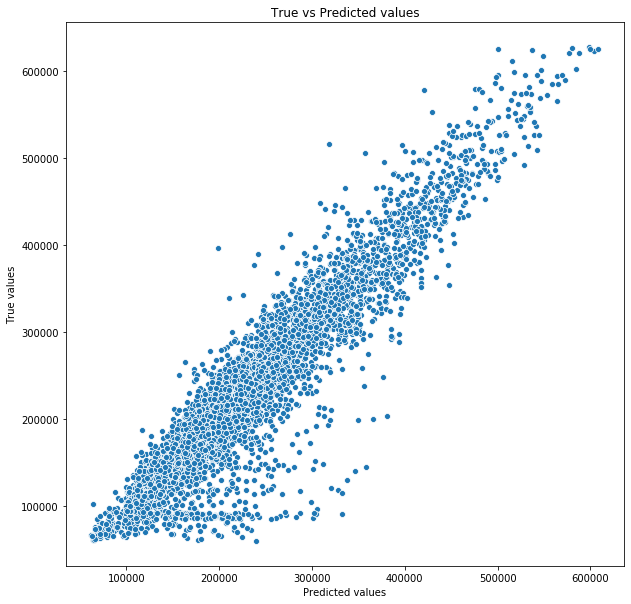

In [73]:
y_pred_=model_best.predict(X_train)
evaluate_preds(y_train, y_pred_)

Прогноз на тестовых данных

R2:	0.744
MAE:	27474.456
MSE:	2246381836.918


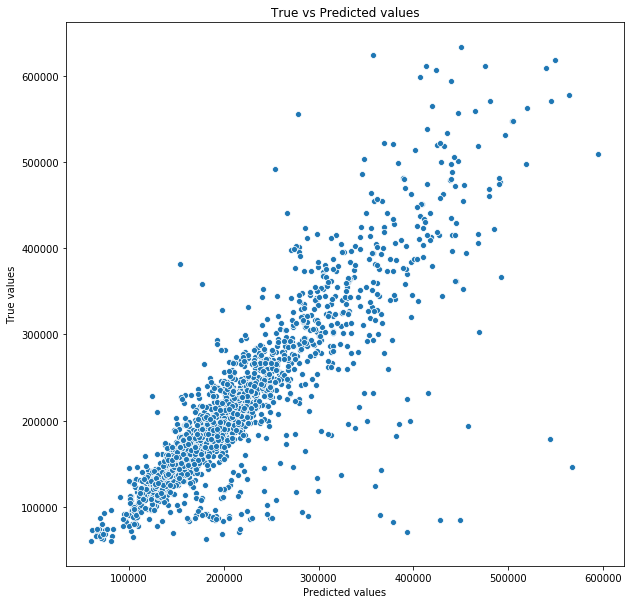

In [74]:
y_pred_t=model_best.predict(X_test)
evaluate_preds(y_test, y_pred_t)

#### <div style="text-align: center ">Важность признаков.</div> 

In [75]:
feature_importances = pd.DataFrame(zip(X_train.columns, model_best.feature_importances_), 
                                   columns=['feature_name', 'importance'])

In [76]:
feature_importances.sort_values(by='importance', ascending=False).head(10)

,feature_name,importance
2,Square,0.417707
10,Social_2,0.091892
9,Social_1,0.090657
11,Social_3,0.081708
1,Rooms,0.066394
0,DistrictId,0.057885
8,Ecology_1,0.045601
7,HouseYear,0.033373
12,Healthcare_1,0.026757
6,HouseFloor,0.018954


### <div style="text-align: center ">Сохранение модели.</div>
* * *  

#### <div style="text-align: center ">Scaler.</div>

In [77]:
with open('model.pkl','wb') as file:
    pickle.dump(scl, file)

#### <div style="text-align: center ">Model.</div> 

In [78]:
with open('scaler.pkl','wb') as file:
    pickle.dump(model_best, file)

.                                                                                                                      .

.                                                                                                                      .

### <div style="text-align: center ">Прогнозирование.</div>
* * *

#### <div style="text-align: center ">Проверка на тренировочном датафрейме.</div> 

In [79]:
DF_train = pickle.load(open('DF_train.pkl', 'rb'))

DF_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3_B,Helthcare_2_0,Helthcare_2_1,Helthcare_2_2,Helthcare_2_3,Helthcare_2_4,Helthcare_2_5,Helthcare_2_6,Shops_2_A,Shops_2_B
0,14038,35,2.0,47.981561,29.442751,6.000000,7,9.0,1969,0.089040,...,1,1,0,0,0,0,0,0,0,1
1,15053,41,3.0,65.683640,40.049543,8.000000,7,9.0,1978,0.000070,...,1,0,1,0,0,0,0,0,0,1
2,4765,53,2.0,44.947953,29.197612,5.395235,8,12.0,1968,0.049637,...,1,0,1,0,0,0,0,0,0,1
3,5809,58,2.0,53.352981,52.731512,9.000000,8,17.0,1977,0.437885,...,1,1,0,0,0,0,0,0,0,1
4,10783,99,1.0,39.649192,23.776169,7.000000,11,12.0,1976,0.012339,...,1,0,0,1,0,0,0,0,0,1


In [80]:
DF_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 29 columns):
Id               10000 non-null int64
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       10000 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     10000 non-null float64
Shops_1          10000 non-null int64
Price            10000 non-null float64
Ecology_2_A      10000 non-null uint8
Ecology_2_B      10000 non-null uint8
Ecology_3_A      10000 non-null uint8
Ecology_3_B      10000 non-null uint8
Helthcare_2_0    10000 non-null uint8
Helthcare_2_1    10000 non-null uint8
Helthcare_2_2    10000 non-null uint8
He

Выделим признаки

In [81]:
feature_=[ 'DistrictId',
             'Rooms',
             'Square',
             'LifeSquare',
             'KitchenSquare',
             'Floor',
             'HouseFloor',
             'HouseYear',
             'Ecology_1',
             'Social_1',
             'Social_2',
             'Social_3',
             'Healthcare_1',
             'Shops_1',
             'Ecology_2_A',
             'Ecology_2_B',
             'Ecology_3_A',
             'Ecology_3_B',
             'Helthcare_2_0',
             'Helthcare_2_1',
             'Helthcare_2_2',
             'Helthcare_2_3',
             'Helthcare_2_4',
             'Helthcare_2_5',
             'Helthcare_2_6',
             'Shops_2_A',
             'Shops_2_B'
         ]
target_ = 'Price'

Объединим в одну таблицу

In [82]:
df = DF_train[feature_ + [target_]]

Импортируем наши StandartScaler и Модель

In [83]:
with open('model.pkl','rb') as file:
     scl_load = pickle.load( file)
    
with open('scaler.pkl','rb') as file:
    model_best_load = pickle.load( file)    

In [84]:
scl_load

StandardScaler(copy=True, with_mean=True, with_std=True)

In [85]:
model_best_load

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=150,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

Стандартизируем данные в тренировочном датасете

In [86]:
X_all = df
X_all

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,Helthcare_2_0,Helthcare_2_1,Helthcare_2_2,Helthcare_2_3,Helthcare_2_4,Helthcare_2_5,Helthcare_2_6,Shops_2_A,Shops_2_B,Price
0,35,2.0,47.981561,29.442751,6.000000,7,9.0,1969,8.903972e-02,33,...,1,0,0,0,0,0,0,0,1,184966.930730
1,41,3.0,65.683640,40.049543,8.000000,7,9.0,1978,6.998930e-05,46,...,0,1,0,0,0,0,0,0,1,300009.450063
2,53,2.0,44.947953,29.197612,5.395235,8,12.0,1968,4.963726e-02,34,...,0,1,0,0,0,0,0,0,1,220925.908524
3,58,2.0,53.352981,52.731512,9.000000,8,17.0,1977,4.378852e-01,23,...,1,0,0,0,0,0,0,0,1,175616.227217
4,99,1.0,39.649192,23.776169,7.000000,11,12.0,1976,1.233889e-02,35,...,0,0,1,0,0,0,0,0,1,150226.531644
5,59,3.0,80.384479,46.683720,12.000000,5,17.0,2011,3.094791e-01,35,...,1,0,0,0,0,0,0,0,1,215898.447742
6,154,2.0,62.254114,37.160377,7.000000,3,5.0,1960,4.605564e-01,20,...,0,1,0,0,0,0,0,0,1,296021.204377
7,74,2.0,80.312926,50.406492,9.640196,14,14.0,1977,7.577876e-02,6,...,1,0,0,0,0,0,0,0,1,221244.156664
8,1,2.0,64.511437,40.489065,7.743497,9,17.0,1977,7.122317e-03,1,...,1,0,0,0,0,0,0,0,1,229102.795999
9,23,1.0,46.461409,18.915552,8.000000,13,17.0,2014,7.577876e-02,6,...,1,0,0,0,0,0,0,0,1,95380.220993


In [87]:
feature_stand_2 = df[feature_].select_dtypes(include = ('int64','float64')).columns.tolist()
feature_stand_2

['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Shops_1']

In [88]:
X_s = scl_load.transform(X_all[feature_stand_2])

In [89]:
X_to_predict = np.hstack((X_s, X_all[['Ecology_2_A',
             'Ecology_2_B',
             'Ecology_3_A',
             'Ecology_3_B',
             'Helthcare_2_0',
             'Helthcare_2_1',
             'Helthcare_2_2',
             'Helthcare_2_3',
             'Helthcare_2_4',
             'Helthcare_2_5',
             'Helthcare_2_6',
             'Shops_2_A',
             'Shops_2_B']].values) )
X_to_predict

array([[-0.35334758,  0.13693641, -0.39578028, ...,  0.        ,
         0.        ,  1.        ],
       [-0.21568684,  1.36837894,  0.44486692, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.05963463,  0.13693641, -0.53984214, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.53689523, -1.09450612, -0.39780109, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.56439067,  0.13693641, -0.60373291, ...,  0.        ,
         0.        ,  1.        ],
       [ 1.78039385, -1.09450612, -0.83813275, ...,  0.        ,
         0.        ,  1.        ]])

Составим прогнозные значения

In [90]:
X = model_best_load.predict(X_to_predict)

In [91]:
X

array([208673.16070121, 257382.75043481, 221462.4028172 , ...,
       140195.08602963, 155631.25147502, 180312.55046555])

Выведем графически результат предсказания на тренировочных данных

R2:	0.853
MAE:	22188.488
MSE:	1268308410.477


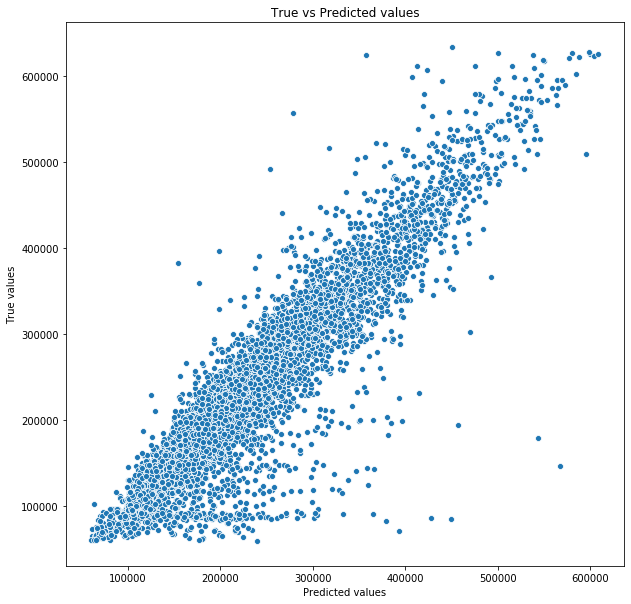

In [92]:
evaluate_preds(DF_train['Price'], X)

#### <div style="text-align: center ">Проверка на тестовом датафрейме.</div> 

In [93]:
DF_test = pickle.load(open('DF_test.pkl', 'rb'))

DF_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3_B,Helthcare_2_0,Helthcare_2_1,Helthcare_2_2,Helthcare_2_3,Helthcare_2_4,Helthcare_2_5,Helthcare_2_6,Shops_2_A,Shops_2_B
0,725,58,2.0,49.882643,33.432782,6.000000,6,14.0,1972,0.310199,...,1,1,0,0,0,0,0,0,0,1
1,15856,74,2.0,69.263183,43.546755,8.434047,6,6.0,1977,0.075779,...,1,1,0,0,0,0,0,0,0,1
2,5480,190,1.0,13.597819,7.740119,12.000000,2,5.0,1909,0.000000,...,1,0,0,0,0,0,1,0,0,1
3,15664,47,2.0,73.046609,51.940842,9.000000,22,22.0,2007,0.101872,...,1,0,0,0,1,0,0,0,0,1
4,14275,27,1.0,47.527111,43.387569,7.941529,17,17.0,2017,0.072158,...,1,1,0,0,0,0,0,0,1,0


In [94]:
DF_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 28 columns):
Id               5000 non-null int64
DistrictId       5000 non-null int64
Rooms            5000 non-null float64
Square           5000 non-null float64
LifeSquare       5000 non-null float64
KitchenSquare    5000 non-null float64
Floor            5000 non-null int64
HouseFloor       5000 non-null float64
HouseYear        5000 non-null int64
Ecology_1        5000 non-null float64
Social_1         5000 non-null int64
Social_2         5000 non-null int64
Social_3         5000 non-null int64
Healthcare_1     5000 non-null float64
Shops_1          5000 non-null int64
Ecology_2_A      5000 non-null uint8
Ecology_2_B      5000 non-null uint8
Ecology_3_A      5000 non-null uint8
Ecology_3_B      5000 non-null uint8
Helthcare_2_0    5000 non-null uint8
Helthcare_2_1    5000 non-null uint8
Helthcare_2_2    5000 non-null uint8
Helthcare_2_3    5000 non-null uint8
Helthcare_2_4    5000 non-nu

Выделим признаки

In [95]:
feature_test=[ 'DistrictId',
             'Rooms',
             'Square',
             'LifeSquare',
             'KitchenSquare',
             'Floor',
             'HouseFloor',
             'HouseYear',
             'Ecology_1',
             'Social_1',
             'Social_2',
             'Social_3',
             'Healthcare_1',
             'Shops_1',
             'Ecology_2_A',
             'Ecology_2_B',
             'Ecology_3_A',
             'Ecology_3_B',
             'Helthcare_2_0',
             'Helthcare_2_1',
             'Helthcare_2_2',
             'Helthcare_2_3',
             'Helthcare_2_4',
             'Helthcare_2_5',
             'Helthcare_2_6',
             'Shops_2_A',
             'Shops_2_B'
         ]


Объединим в одну таблицу

In [96]:
df_test = DF_test[feature_test]

Импортируем наши StandartScaler и Модель

In [97]:
with open('model.pkl','rb') as file:
     scl_test = pickle.load( file)
    
with open('scaler.pkl','rb') as file:
    model_best_test = pickle.load( file)    

In [98]:
scl_test

StandardScaler(copy=True, with_mean=True, with_std=True)

In [99]:
model_best_test

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=150,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

Стандартизируем данные в тренировочном датасете

In [100]:
X_all_test = df_test
X_all_test

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,Ecology_3_B,Helthcare_2_0,Helthcare_2_1,Helthcare_2_2,Helthcare_2_3,Helthcare_2_4,Helthcare_2_5,Helthcare_2_6,Shops_2_A,Shops_2_B
0,58,2.0,49.882643,33.432782,6.000000,6,14.0,1972,0.310199,11,...,1,1,0,0,0,0,0,0,0,1
1,74,2.0,69.263183,43.546755,8.434047,6,6.0,1977,0.075779,6,...,1,1,0,0,0,0,0,0,0,1
2,190,1.0,13.597819,7.740119,12.000000,2,5.0,1909,0.000000,30,...,1,0,0,0,0,0,1,0,0,1
3,47,2.0,73.046609,51.940842,9.000000,22,22.0,2007,0.101872,23,...,1,0,0,0,1,0,0,0,0,1
4,27,1.0,47.527111,43.387569,7.941529,17,17.0,2017,0.072158,2,...,1,1,0,0,0,0,0,0,1,0
5,53,1.0,40.675627,23.153286,6.796682,21,21.0,1977,0.049637,34,...,1,0,1,0,0,0,0,0,0,1
6,23,2.0,68.099538,64.843025,8.292353,2,17.0,1977,0.075779,6,...,1,1,0,0,0,0,0,0,0,1
7,32,2.0,48.193897,32.857644,6.000000,5,14.0,1972,0.135650,46,...,1,0,0,0,1,0,0,0,0,1
8,96,3.0,72.277106,45.968758,9.000000,17,17.0,1997,0.041116,53,...,1,0,1,0,0,0,0,0,0,1
9,6,3.0,80.219400,47.660260,9.000000,13,17.0,2014,0.243205,5,...,1,1,0,0,0,0,0,0,0,1


In [101]:
feature_stand_test = df_test[feature_test].select_dtypes(include = ('int64','float64')).columns.tolist()
feature_stand_test

['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Shops_1']

In [102]:
X_s_test = scl_test.transform(X_all_test[feature_stand_test])

In [103]:
X_to_predict_test = np.hstack((X_s_test, X_all_test[['Ecology_2_A',
             'Ecology_2_B',
             'Ecology_3_A',
             'Ecology_3_B',
             'Helthcare_2_0',
             'Helthcare_2_1',
             'Helthcare_2_2',
             'Helthcare_2_3',
             'Helthcare_2_4',
             'Helthcare_2_5',
             'Helthcare_2_6',
             'Shops_2_A',
             'Shops_2_B']].values) )
X_to_predict_test

array([[ 0.17435191,  0.13693641, -0.30550052, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.54144721,  0.13693641,  0.61485449, ...,  0.        ,
         0.        ,  1.        ],
       [ 3.20288814, -1.09450612, -2.0286166 , ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.88104708,  1.36837894,  1.02225905, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.26612574,  0.13693641,  1.18671422, ...,  0.        ,
         1.        ,  0.        ],
       [-0.46806486,  0.13693641,  0.20134781, ...,  0.        ,
         0.        ,  1.        ]])

Составим прогнозные значения

In [104]:
test = model_best_test.predict(X_to_predict_test)

In [105]:
test

array([151133.07377007, 212798.20529072,  97186.66122246, ...,
       334275.25216666, 188473.42820579, 189497.12295584])

### Сохранение результата

In [106]:
DF_test['Price']=test

In [107]:
DF_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2_0,Helthcare_2_1,Helthcare_2_2,Helthcare_2_3,Helthcare_2_4,Helthcare_2_5,Helthcare_2_6,Shops_2_A,Shops_2_B,Price
0,725,58,2.0,49.882643,33.432782,6.000000,6,14.0,1972,0.310199,...,1,0,0,0,0,0,0,0,1,151133.073770
1,15856,74,2.0,69.263183,43.546755,8.434047,6,6.0,1977,0.075779,...,1,0,0,0,0,0,0,0,1,212798.205291
2,5480,190,1.0,13.597819,7.740119,12.000000,2,5.0,1909,0.000000,...,0,0,0,0,0,1,0,0,1,97186.661222
3,15664,47,2.0,73.046609,51.940842,9.000000,22,22.0,2007,0.101872,...,0,0,0,1,0,0,0,0,1,373596.180758
4,14275,27,1.0,47.527111,43.387569,7.941529,17,17.0,2017,0.072158,...,1,0,0,0,0,0,0,1,0,138806.570210


Посмотрим какой вклад вносит каждый признак

In [108]:
DF_feature_importances_ = pd.DataFrame(zip(DF_test.columns, model_best_test.feature_importances_), 
                                   columns=['feature_name', 'importance'])

In [109]:
DF_feature_importances_.sort_values(by = 'importance', ascending = False).head(10)

,feature_name,importance
2,Rooms,0.417707
10,Social_1,0.091892
9,Ecology_1,0.090657
11,Social_2,0.081708
1,DistrictId,0.066394
0,Id,0.057885
8,HouseYear,0.045601
7,HouseFloor,0.033373
12,Social_3,0.026757
6,Floor,0.018954


In [110]:
DF_finish = pd.DataFrame(zip(DF_test.Id, DF_test.Price), 
                                   columns=['Id', 'Price'])

In [111]:
DF_finish.head()

,Id,Price
0,725,151133.073770
1,15856,212798.205291
2,5480,97186.661222
3,15664,373596.180758
4,14275,138806.570210


In [112]:
DF_finish.to_csv(path_or_buf='BaburkinAS_prediction.csv', sep=',', header=True, index=False)

## P.S. (визуальная проверка "похожести" результатов)

In [113]:
price_by_room_train = DF_train.groupby(DF_train['Rooms']).Price.median()
price_by_room_train

Rooms
1.0    154979.497993
2.0    200332.511658
3.0    268723.157677
4.0    377524.231990
5.0    455355.638212
6.0    229661.964416
Name: Price, dtype: float64

In [114]:
price_by_room_test = DF_test.groupby(DF_test['Rooms']).Price.median()
price_by_room_test

Rooms
1.0    159233.665959
2.0    200994.281073
3.0    270367.538943
4.0    373586.382871
5.0    337192.540768
6.0    357127.159337
Name: Price, dtype: float64

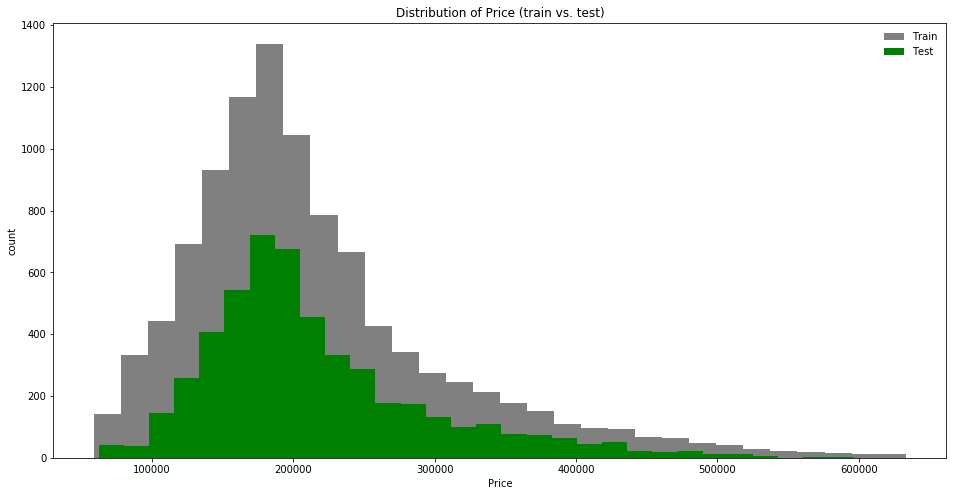

In [115]:
plt.figure(figsize = (16, 8))

plt.hist(DF_train['Price'], label='Train', color='gray', bins=30)
plt.hist(DF_test['Price'], label='Test', color='green', bins=30)

plt.ylabel('count')
plt.xlabel('Price')

plt.title('Distribution of Price (train vs. test)')
plt.legend(loc='upper right', frameon=False)
plt.show()

Распределение прогнозных цен имеет тот же вид, что и тренировочные, на основе этого можно сделать вывод что прогноз получился корректный ... вопрос лишь в том, насколько точным он оказался)))